<a href="https://colab.research.google.com/github/farshidehkordi/Homework2_AI/blob/main/TP2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import os


# List files in the current directory
print(os.listdir())


['.config', 'drive', 'sample_data']


In [4]:
import os

# List files in the current directory
print(os.listdir())

# Check if the uploaded file exists
if 'CUB_200_2011.tar' in os.listdir():
    print("File exists!")
else:
    print("File not found.")


['.config', 'drive', 'sample_data']
File not found.


In [5]:
import tarfile

# open file
file = tarfile.open('/content/drive/MyDrive/CUB_200_2011.tar')



# extract files
file.extractall('./CUB_dataset')

# close file
file.close()


In [6]:
import os
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from shutil import copyfile


# Function to create a directory if it doesn't exist
def make_dir(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)

# Function to separate images into training and test sets
def separate_train_test(dataset_path, train_path, test_path):
    class_index = 1
    for classname in sorted(os.listdir(dataset_path)):
        if classname.startswith('.'):
            continue
        make_dir(os.path.join(train_path, classname))
        make_dir(os.path.join(test_path, classname))
        i = 0
        for file in sorted(os.listdir(os.path.join(dataset_path, classname))):
            if file.startswith('.'):
                continue
            file_path = os.path.join(dataset_path, classname, file)
            if i < 15:  # Number of images for the test set
                copyfile(file_path, os.path.join(test_path, classname, file))
            else:
                copyfile(file_path, os.path.join(train_path, classname, file))
            i += 1
        class_index += 1







In [7]:
dataset_path = './CUB_dataset/CUB_200_2011/images'
train_path = './CUB_dataset/train'
test_path  = './CUB_dataset/test'

# Call the function to separate the dataset into training and test sets
separate_train_test(dataset_path, train_path, test_path)

ResNet18 using random initialization use the values from the training dataset to normalize the data.



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),                # Resize images to 224x224 pixels
    transforms.ToTensor(),                         # Convert images to PyTorch tensors
])

# Load the training and test datasets
train_dataset = ImageFolder(root='./CUB_dataset/train', transform=transform)
test_dataset = ImageFolder(root='./CUB_dataset/test', transform=transform)

# Calculate mean and standard deviation from the training dataset
mean = torch.zeros(3)  # Initialize mean tensor
std = torch.zeros(3)   # Initialize standard deviation tensor

for image, _ in train_dataset:
    # Add pixel values of each channel to the mean tensor
    mean += torch.mean(image, dim=(1, 2))
    # Add standard deviation of each channel to the std tensor
    std += torch.std(image, dim=(1, 2))

# Calculate mean and standard deviation for the entire dataset
mean /= len(train_dataset)
std /= len(train_dataset)

print("Mean values for each channel:", mean)
print("Standard deviation values for each channel:", std)

# Define data transformations with normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),                # Resize images to 224x224 pixels
    transforms.ToTensor(),                         # Convert images to PyTorch tensors
    transforms.Normalize(mean, std)                # Normalize images using computed mean and std
])

# Update the datasets with the new transformations
train_dataset = ImageFolder(root='./CUB_dataset/train', transform=transform)
test_dataset = ImageFolder(root='./CUB_dataset/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the ResNet18 model with random initialization
model =resnet18(weights=None)

# Adapt the fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')


Mean values for each channel: tensor([0.4875, 0.5013, 0.4342])
Standard deviation values for each channel: tensor([0.1749, 0.1738, 0.1861])
Epoch [1/10], Loss: 5.2929816523465245
Epoch [2/10], Loss: 5.114674823067405
Epoch [3/10], Loss: 4.924547113938765
Epoch [4/10], Loss: 4.760703919150613
Epoch [5/10], Loss: 4.6124801861156115
Epoch [6/10], Loss: 4.503838197534734
Epoch [7/10], Loss: 4.395520323840055
Epoch [8/10], Loss: 4.288472587412054


ResNet18 using random initialization use the values from ImageNet

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18 , ResNet18_Weights
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize images
])

# Load the training and test datasets
train_dataset = ImageFolder(root='./CUB_dataset/train', transform=transform)
test_dataset = ImageFolder(root='./CUB_dataset/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the pre-trained ResNet18 model
model =resnet18(weights=None)


# Adapt the fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')


Epoch [1/10], Loss: 4.809893293380737
Epoch [2/10], Loss: 3.3419612164930865
Epoch [3/10], Loss: 2.425194742462852
Epoch [4/10], Loss: 1.8303259918906472
Epoch [5/10], Loss: 1.4222531648115677
Epoch [6/10], Loss: 1.1195163646611301
Epoch [7/10], Loss: 0.8801681715791876
Epoch [8/10], Loss: 0.6957529464634982
Epoch [9/10], Loss: 0.5466226833516901
Epoch [10/10], Loss: 0.4296421061320738
Accuracy on test set: 70.10%


ResNet18 using pretrained model on CUB_200 dataset use the values from the training dataset to normalize the data, but freezing all the convolution parameters

> Add blockquote



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18 , ResNet18_Weights

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),                # Resize images to 224x224 pixels
    transforms.ToTensor(),                         # Convert images to PyTorch tensors
])

# Load the training and test datasets
train_dataset = ImageFolder(root='./CUB_dataset/train', transform=transform)
test_dataset = ImageFolder(root='./CUB_dataset/test', transform=transform)

# Calculate mean and standard deviation from the training dataset
mean = torch.zeros(3)  # Initialize mean tensor
std = torch.zeros(3)   # Initialize standard deviation tensor

for image, _ in train_dataset:
    # Add pixel values of each channel to the mean tensor
    mean += torch.mean(image, dim=(1, 2))
    # Add standard deviation of each channel to the std tensor
    std += torch.std(image, dim=(1, 2))

# Calculate mean and standard deviation for the entire dataset
mean /= len(train_dataset)
std /= len(train_dataset)

print("Mean values for each channel:", mean)
print("Standard deviation values for each channel:", std)

# Define data transformations with normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),                # Resize images to 224x224 pixels
    transforms.ToTensor(),                         # Convert images to PyTorch tensors
    transforms.Normalize(mean, std)                # Normalize images using computed mean and std
])

# Update the datasets with the new transformations
train_dataset = ImageFolder(root='./CUB_dataset/train', transform=transform)
test_dataset = ImageFolder(root='./CUB_dataset/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the ResNet18 model with pre-trained weights
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Freeze conv1 and bn1 parameters
for param in model.conv1.parameters():
    param.requires_grad = False
for param in model.bn1.parameters():
    param.requires_grad = False

# Freeze convolution and batch norm parameters within each BasicBlock
for layer in [model.layer1, model.layer2, model.layer3, model.layer4]:
    for block in layer:
        for param in block.conv1.parameters():
            param.requires_grad = False
        for param in block.bn1.parameters():
            param.requires_grad = False
        for param in block.conv2.parameters():
            param.requires_grad = False
        for param in block.bn2.parameters():
            param.requires_grad = False


# Replace the fully connected layer with a new one (unfrozen)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)  # Only optimize the fully connected layer

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 38.6MB/s]


Epoch [1/10], Loss: 5.124582522999156
Epoch [2/10], Loss: 4.462770146456632
Epoch [3/10], Loss: 3.947295668341897
Epoch [4/10], Loss: 3.5296648259596393
Epoch [5/10], Loss: 3.192490868134932
Epoch [6/10], Loss: 2.9160115744850854
Epoch [7/10], Loss: 2.6903091968189585
Epoch [8/10], Loss: 2.5028984637693927
Epoch [9/10], Loss: 2.344278058572249
Epoch [10/10], Loss: 2.2109826317700474
Accuracy on test set: 50.40%


Resnet18 using pretraind model for Freeze all layers use the values from ImageNet.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 78.6MB/s]


Epoch [1/10], Loss: 5.113590323708274
Accuracy on test set: 10.03%
Epoch [2/10], Loss: 4.457570089860396
Accuracy on test set: 21.67%
Epoch [3/10], Loss: 3.9354529146714645
Accuracy on test set: 29.33%
Epoch [4/10], Loss: 3.519543093768033
Accuracy on test set: 37.00%
Epoch [5/10], Loss: 3.190919953259555
Accuracy on test set: 39.63%
Epoch [6/10], Loss: 2.9157252103632145
Accuracy on test set: 43.57%
Epoch [7/10], Loss: 2.697276924306696
Accuracy on test set: 46.53%
Epoch [8/10], Loss: 2.5035677472027866
Accuracy on test set: 46.80%
Epoch [9/10], Loss: 2.3487806259502064
Accuracy on test set: 48.43%
Epoch [10/10], Loss: 2.2089147866855967
Accuracy on test set: 50.00%


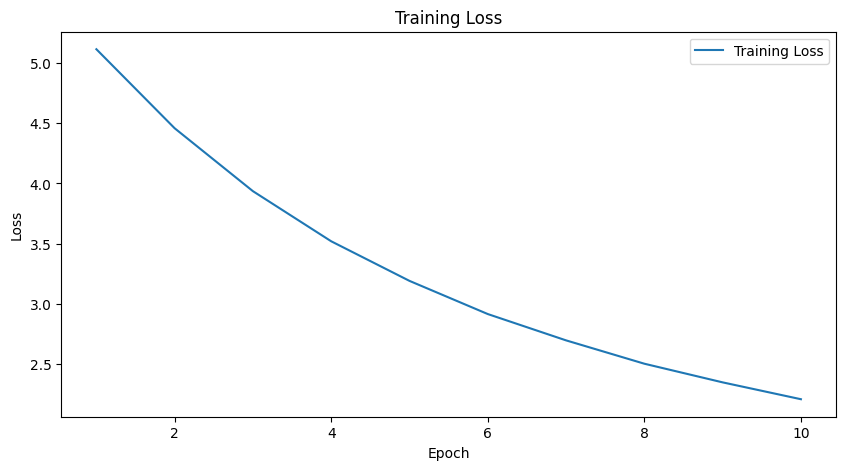

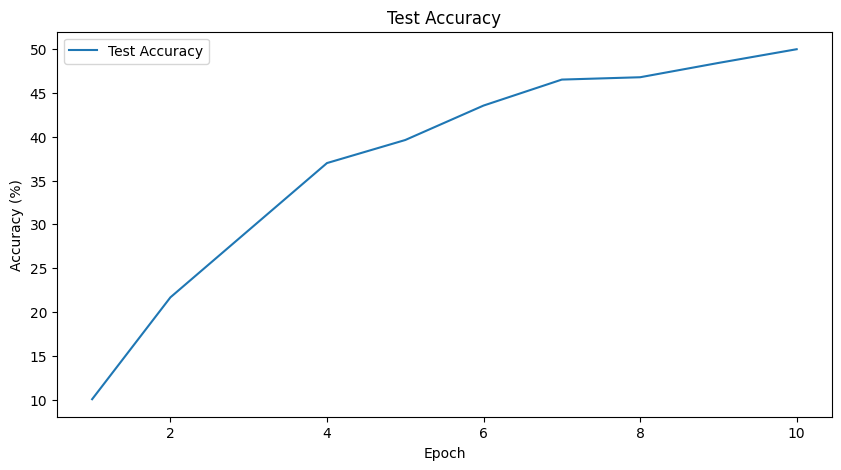

In [8]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize images
])

# Load the training and test datasets
train_dataset = ImageFolder(root='./CUB_dataset/train', transform=transform)
test_dataset = ImageFolder(root='./CUB_dataset/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Load the pre-trained ResNet model
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Freeze conv1 and bn1 parameters
for param in model.conv1.parameters():
    param.requires_grad = False
for param in model.bn1.parameters():
    param.requires_grad = False

# Freeze convolution and batch norm parameters within each BasicBlock
for layer in [model.layer1, model.layer2, model.layer3, model.layer4]:
    for block in layer:
        for param in block.conv1.parameters():
            param.requires_grad = False
        for param in block.bn1.parameters():
            param.requires_grad = False
        for param in block.conv2.parameters():
            param.requires_grad = False
        for param in block.bn2.parameters():
            param.requires_grad = False
# Adapt the fully connected layer to match the number of classes in your dataset
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(train_dataset.classes))  # Change the output size of the fully connected layer

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Lists to store loss and accuracy values
train_losses = []
test_accuracies = []

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss}')

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    print(f'Accuracy on test set: {test_accuracy:.2f}%')




ResNet18 using the pre-trained model use the values from the training dataset to normalize the data, but only freezing the
parameters in "layer1" on CUB_200 dataset

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18 , ResNet18_Weights
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),                # Resize images to 224x224 pixels
    transforms.ToTensor(),                         # Convert images to PyTorch tensors
])

# Load the training and test datasets
train_dataset = ImageFolder(root='./CUB_dataset/train', transform=transform)
test_dataset = ImageFolder(root='./CUB_dataset/test', transform=transform)

# Calculate mean and standard deviation from the training dataset
mean = torch.zeros(3)  # Initialize mean tensor
std = torch.zeros(3)   # Initialize standard deviation tensor

for image, _ in train_dataset:
    # Add pixel values of each channel to the mean tensor
    mean += torch.mean(image, dim=(1, 2))
    # Add standard deviation of each channel to the std tensor
    std += torch.std(image, dim=(1, 2))

# Calculate mean and standard deviation for the entire dataset
mean /= len(train_dataset)
std /= len(train_dataset)

print("Mean values for each channel:", mean)
print("Standard deviation values for each channel:", std)

# Define data transformations with normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),                # Resize images to 224x224 pixels
    transforms.ToTensor(),                         # Convert images to PyTorch tensors
    transforms.Normalize(mean, std)                # Normalize images using computed mean and std
])

# Update the datasets with the new transformations
train_dataset = ImageFolder(root='./CUB_dataset/train', transform=transform)
test_dataset = ImageFolder(root='./CUB_dataset/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the pre-trained ResNet18 model
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Freeze conv1 and bn1 parameters in layer1
for name, param in model.layer1.named_parameters():
    if 'conv1' in name or 'bn1' in name:
        param.requires_grad = False


# Adapt the fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')


Epoch [1/10], Loss: 4.809893293380737
Epoch [2/10], Loss: 3.3419612164930865
Epoch [3/10], Loss: 2.425194742462852
Epoch [4/10], Loss: 1.8303259918906472
Epoch [5/10], Loss: 1.4222531648115677
Epoch [6/10], Loss: 1.1195163646611301
Epoch [7/10], Loss: 0.8801681715791876
Epoch [8/10], Loss: 0.6957529464634982
Epoch [9/10], Loss: 0.5466226833516901
Epoch [10/10], Loss: 0.4296421061320738
Accuracy on test set: 70.10%


ResNet18 using the pre-trained model use the values from the ImageNet to normalize the data, but only freezing the
parameters in "layer1" on CUB_200 dataset

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18 , ResNet18_Weights
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize images
])

# Load the training and test datasets
train_dataset = ImageFolder(root='./CUB_dataset/train', transform=transform)
test_dataset = ImageFolder(root='./CUB_dataset/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the pre-trained ResNet18 model
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Freeze conv1 and bn1 parameters in layer1
for name, param in model.layer1.named_parameters():
    if 'conv1' in name or 'bn1' in name:
        param.requires_grad = False


# Adapt the fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')


Epoch [1/10], Loss: 4.809893293380737
Epoch [2/10], Loss: 3.3419612164930865
Epoch [3/10], Loss: 2.425194742462852
Epoch [4/10], Loss: 1.8303259918906472
Epoch [5/10], Loss: 1.4222531648115677
Epoch [6/10], Loss: 1.1195163646611301
Epoch [7/10], Loss: 0.8801681715791876
Epoch [8/10], Loss: 0.6957529464634982
Epoch [9/10], Loss: 0.5466226833516901
Epoch [10/10], Loss: 0.4296421061320738
Accuracy on test set: 70.10%


ResNet18 using the pre-trained model on CUB_200 dataset use the values from the training dataset to normalize the data, but letting all the parameters (including the convolution
layers) be adjusted by backprop.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize images
])

# Load the training and test datasets
train_dataset = ImageFolder(root='./CUB_dataset/train', transform=transform)
test_dataset = ImageFolder(root='./CUB_dataset/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the pre-trained ResNet18 model
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Adapt the fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')


FileNotFoundError: [Errno 2] No such file or directory: './CUB_dataset/train'

ResNet18 using the pre-trained model on CUB_200 dataset use ImageNet to normalize the data, but letting all the parameters (including the convolution
layers) be adjusted by backprop

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),                # Resize images to 224x224 pixels
    transforms.ToTensor(),                         # Convert images to PyTorch tensors
])

# Load the training and test datasets
train_dataset = ImageFolder(root='./CUB_dataset/train', transform=transform)
test_dataset = ImageFolder(root='./CUB_dataset/test', transform=transform)

# Calculate mean and standard deviation from the training dataset
mean = torch.zeros(3)  # Initialize mean tensor
std = torch.zeros(3)   # Initialize standard deviation tensor

for image, _ in train_dataset:
    # Add pixel values of each channel to the mean tensor
    mean += torch.mean(image, dim=(1, 2))
    # Add standard deviation of each channel to the std tensor
    std += torch.std(image, dim=(1, 2))

# Calculate mean and standard deviation for the entire dataset
mean /= len(train_dataset)
std /= len(train_dataset)

print("Mean values for each channel:", mean)
print("Standard deviation values for each channel:", std)

# Define data transformations with normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),                # Resize images to 224x224 pixels
    transforms.ToTensor(),                         # Convert images to PyTorch tensors
    transforms.Normalize(mean, std)                # Normalize images using computed mean and std
])

# Update the datasets with the new transformations
train_dataset = ImageFolder(root='./CUB_dataset/train', transform=transform)
test_dataset = ImageFolder(root='./CUB_dataset/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the pre-trained ResNet18 model
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Adapt the fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')


FileNotFoundError: [Errno 2] No such file or directory: './CUB_dataset/train'